<h1> Task 1 - Setting the baseline <h1>

<h2> Task 1.1 - Data preparation and validation pipeline <h2>

<h3> Import librarys <h3>

In [1]:
import matplotlib.pyplot as plt                        # Library for plotting graphs and visualizations
import numpy as np                                     # Library for numerical computing (arrays, math functions)
import pandas as pd                                    # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
from sklearn.preprocessing import FunctionTransformer  # Apply custom functions to transform data
from sklearn.neighbors import KNeighborsRegressor      # k-Nearest Neighbors regression model
from sklearn.multioutput import MultiOutputRegressor   # Extend regressors to multi-output problems
import math                                            # Python built-in math library
import time                                            # Python built-in library to measure execution time
import seaborn as sns                                  #Statistical data visualization                           
import os                                              #Python built-in library for operating system interactions
import missingno as msno                               #Library for visualizing missing data
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, cross_validate #Cross-validation utilities


<h3> Missing data visualization <h3>

<Axes: >

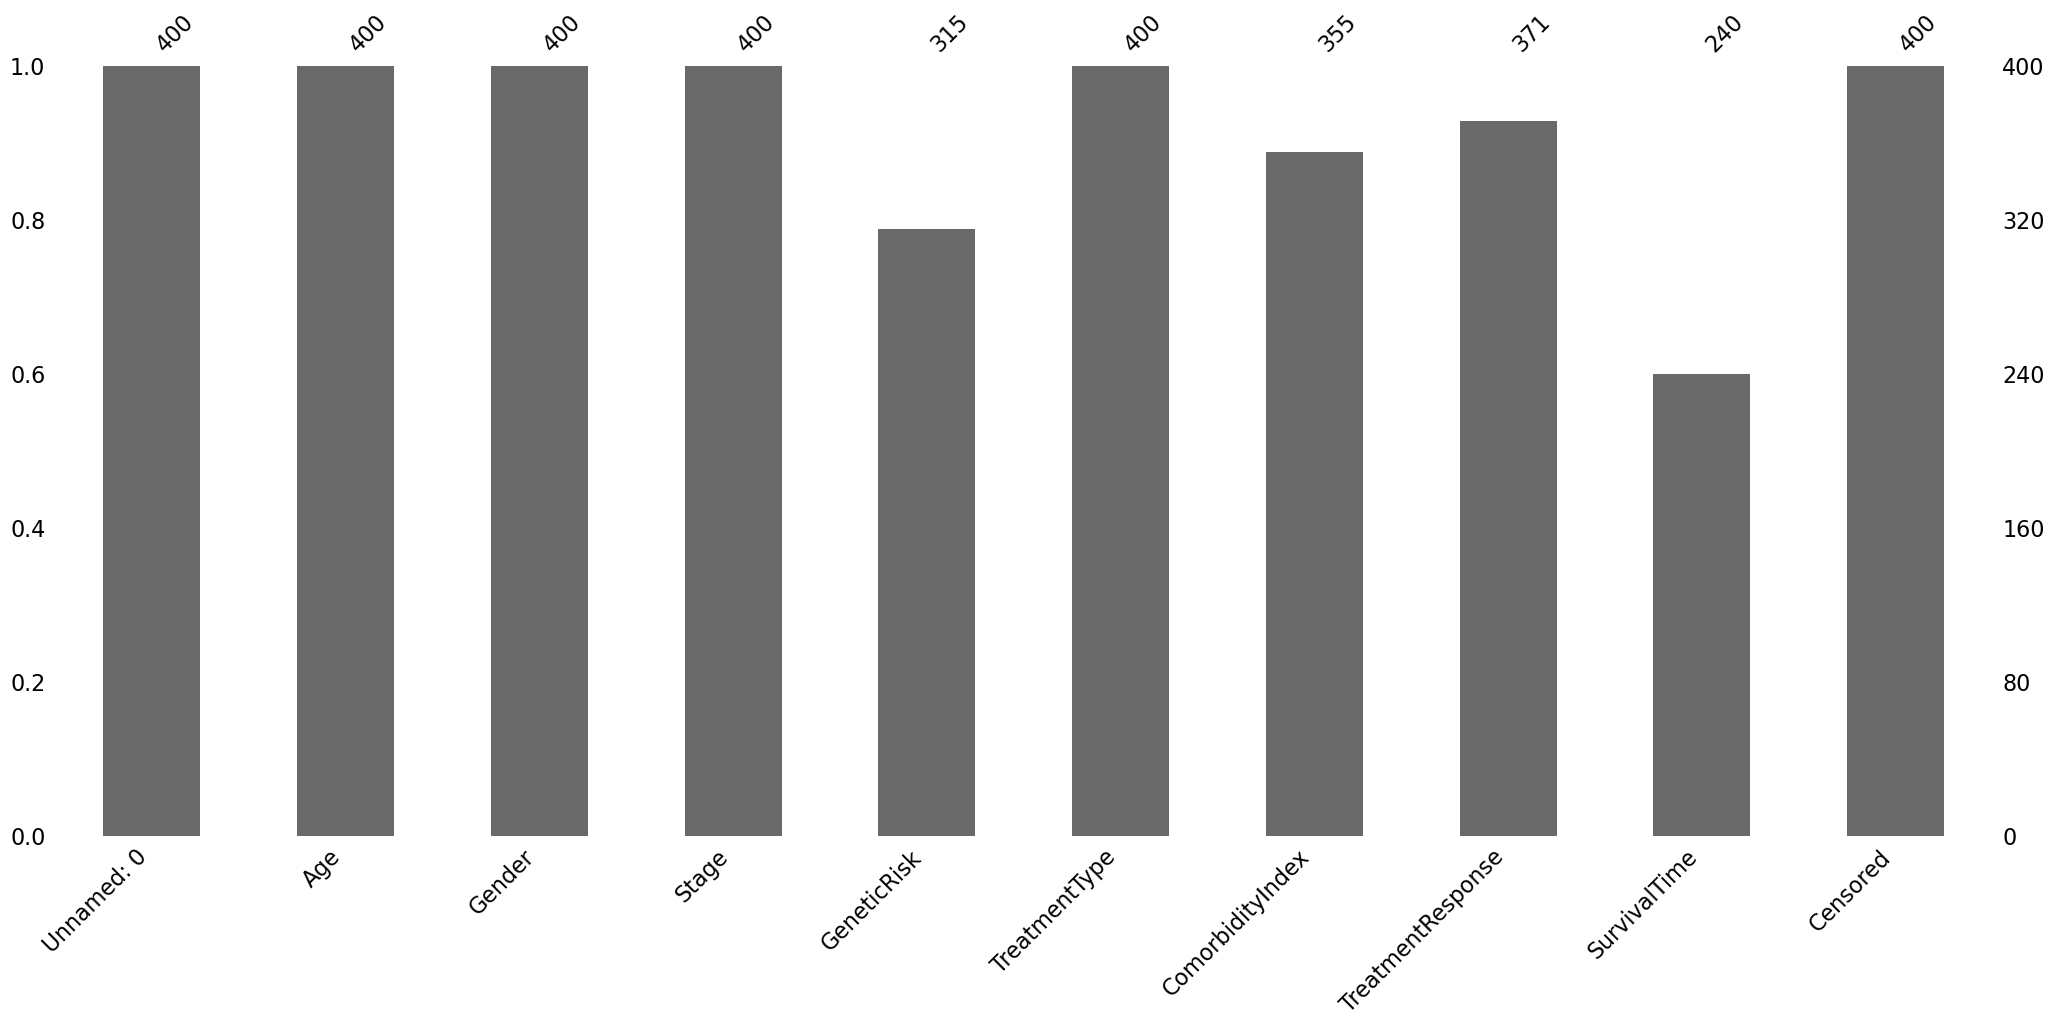

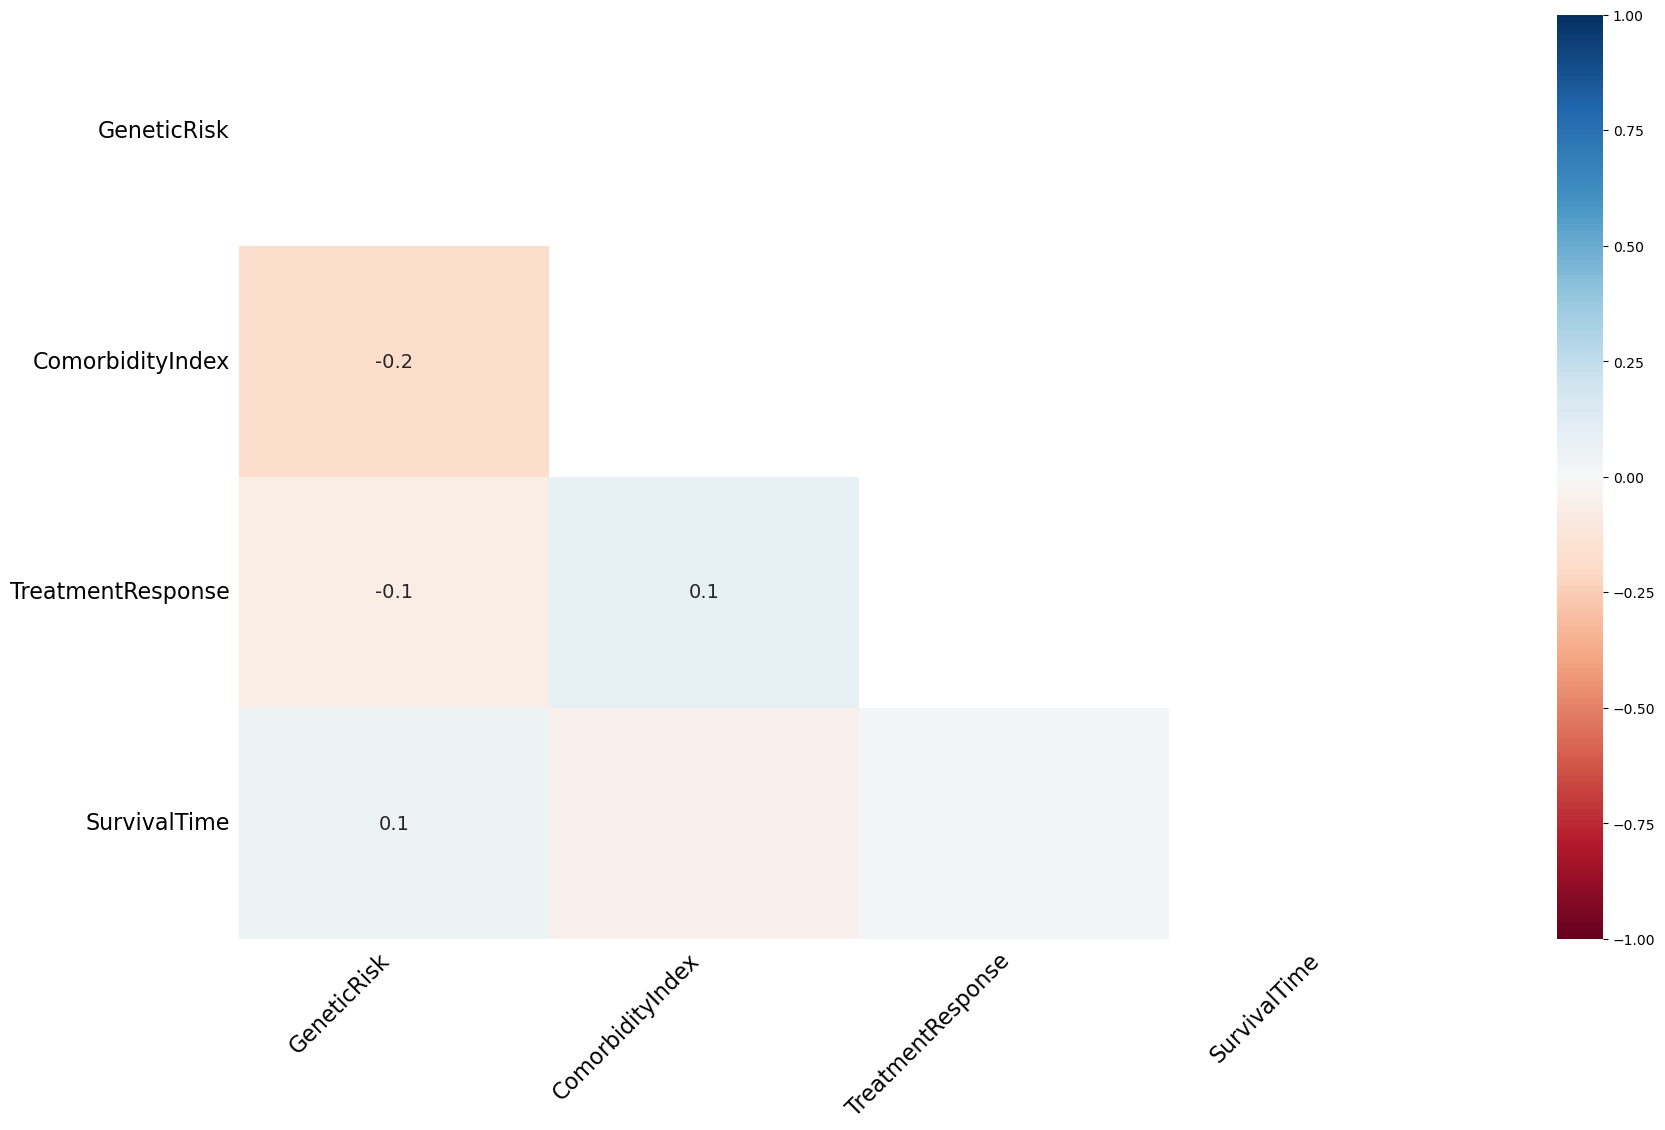

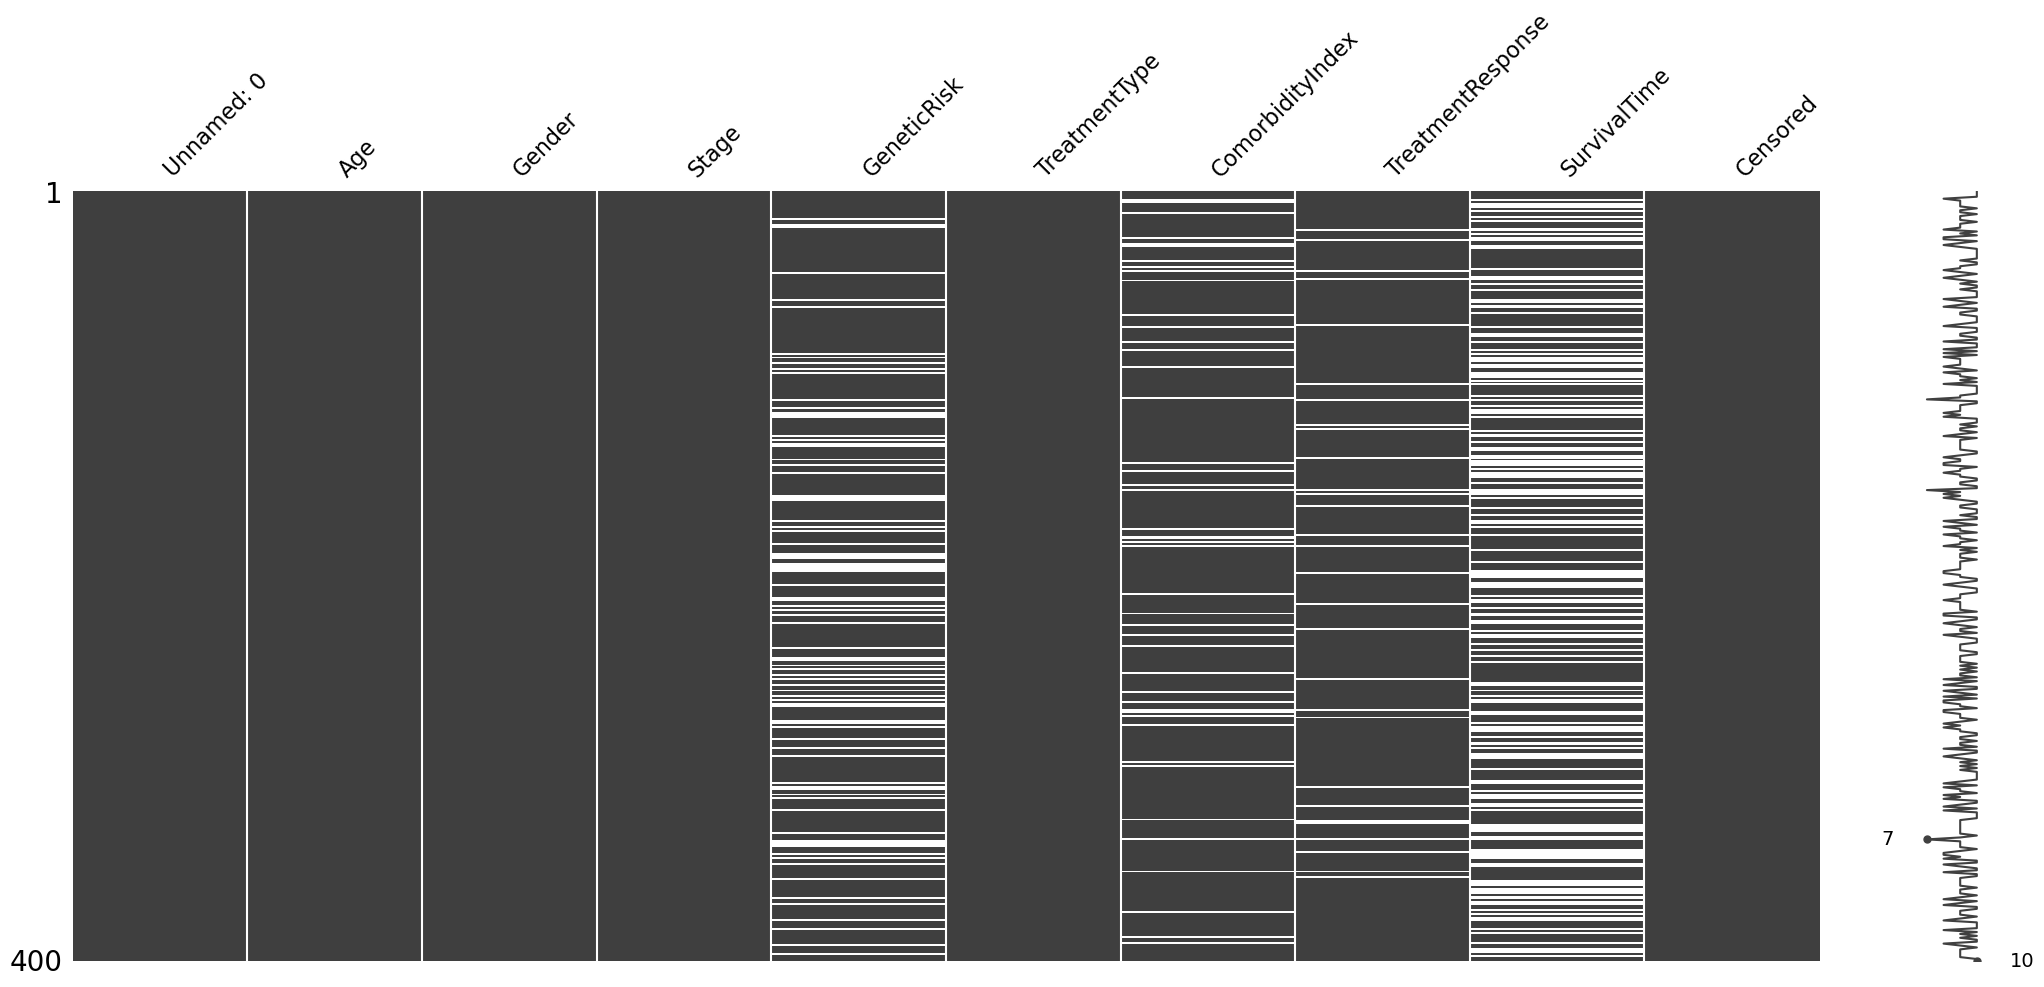

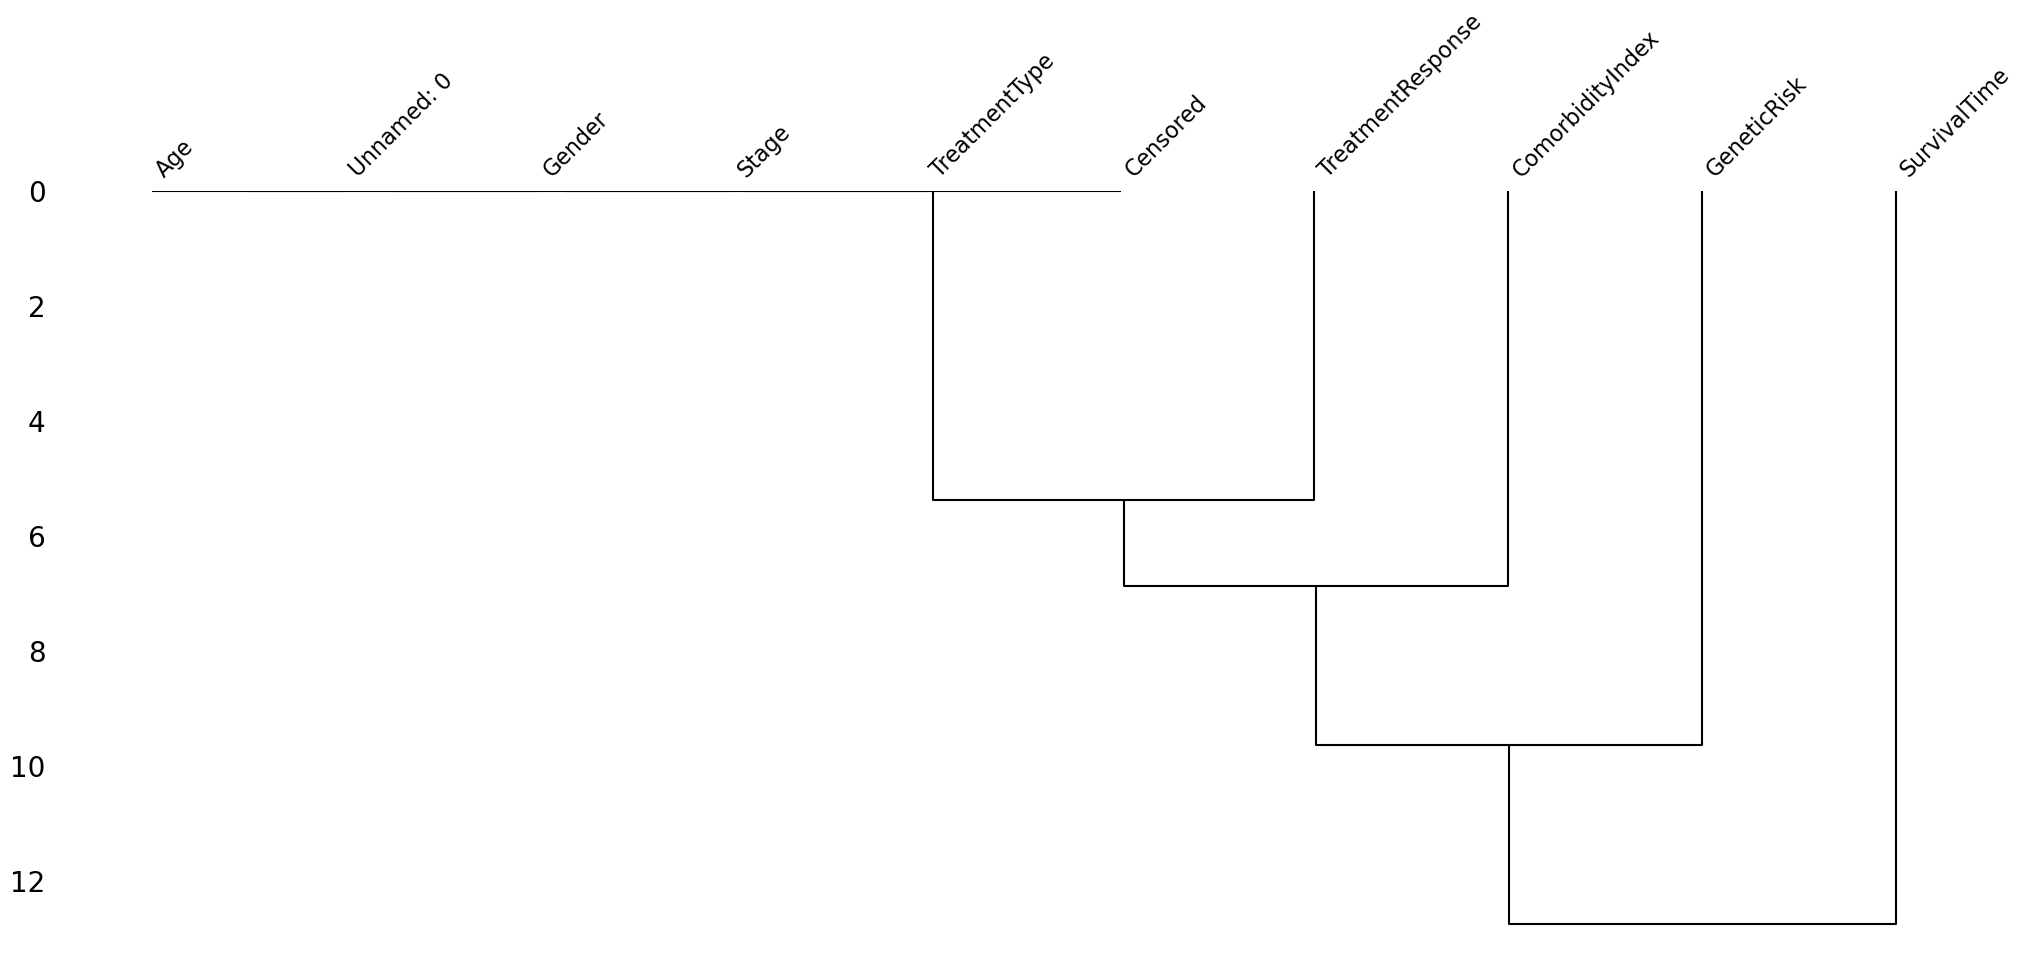

In [2]:
train = pd.read_csv("../data/train_data.csv")
test  = pd.read_csv("../data/test_data.csv")

msno.bar(train)
msno.heatmap(train)
msno.matrix(train)
msno.dendrogram(train)                                        

<h3> Droupout lines: missing values and censored <h3>

In [3]:
#Dataset Analysis before the droupout
print("Initial Analysis of the training set:")
print(f"Total training exemples: {len(train)}")
print(f"\nMissing values per column:")
print(train.isnull().sum())
print(f"Censored exemples: {train['Censored'].sum()} ({100*train['Censored'].sum()/len(train):.1f}%)")
print(f"Non Censored exemples: {(train['Censored']==0).sum()} ({100*(train['Censored']==0).sum()/len(train):.1f}%)")

#Droupout lines with missing values 
#Columns with missing values
cols_to_check = ["TreatmentResponse", "GeneticRisk", "ComorbidityIndex", "SurvivalTime"]

#Remove every line with at least one missing value in the specified columns
train_clean = train.dropna(subset=cols_to_check)
print("Number of lines without missing values:", len(train_clean))

#Dropout lines with censored
#Remove every line with Censored=1
train_final = train_clean[train_clean["Censored"] == 0]

print("Number of lines withou censored values:", len(train_final))

Initial Analysis of the training set:
Total training exemples: 400

Missing values per column:
Unnamed: 0             0
Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64
Censored exemples: 79 (19.8%)
Non Censored exemples: 321 (80.2%)
Number of lines without missing values: 153
Number of lines withou censored values: 109


<h3> Pairplot between target (Survival Time) and Features <h3>

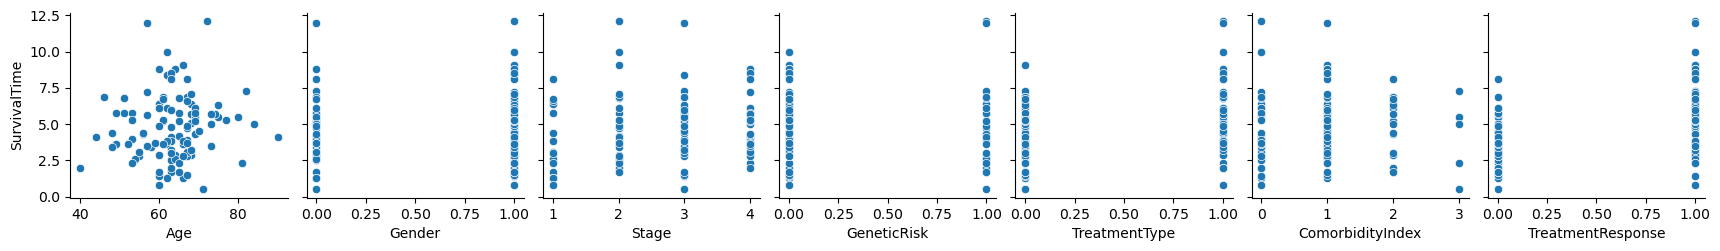

In [4]:
#Define target and features
target = "SurvivalTime"
features = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex",
    "TreatmentResponse"]

df = train_final[features + [target]]

# Features we use in models (without missing in train and test)
model_features = ["Age", "Gender", "Stage", "TreatmentType"]

#Creating pairplot
sns.pairplot(df, y_vars=[target], x_vars=features)
plt.show()

<h3> Matrix of X and vector of Y <h3>

In [5]:
#Creating the matrix and the vector 
X = train_final[model_features].values
y = train_final["SurvivalTime"].values  

<h3> Comparing Splitting Strategies <h3>

In [6]:
n_total = len(train_final)

#Train/Val/Test split (60/20/20)
train_size_1 = int(0.6 * n_total)
val_size_1 = int(0.2 * n_total)
test_size_1 = n_total - train_size_1 - val_size_1

print(f"Train/Val/Test (60/20/20):")
print(f"Train: {train_size_1} exemples")
print(f"Val: {val_size_1} exemples")
print(f"Test: {test_size_1} exemples")

#Train/Test + 5-Fold CV
train_size_2 = int(0.8 * n_total)
test_size_2 = n_total - train_size_2

print(f"Train/Test (80/20) + 5-Fold CV:")
print(f"Train: {train_size_2} exemplos")
print(f"Test: {test_size_2} exemplos")
print(f"Each fold in train in CV: ~{int(0.8 * train_size_2)} exemples")
print(f"Each fold in validation in CV: ~{int(0.2 * train_size_2)} exemples")

Train/Val/Test (60/20/20):
Train: 65 exemples
Val: 21 exemples
Test: 23 exemples
Train/Test (80/20) + 5-Fold CV:
Train: 87 exemplos
Test: 22 exemplos
Each fold in train in CV: ~69 exemples
Each fold in validation in CV: ~17 exemples


<h3> Defining new metric cMSE <h3>

In [7]:
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

<h2> Task 1.2 - Learn the baseline model <h2>

Train size: 87
Test size: 22
Cross-validated MSE: 4.481477766670382
Final Test MSE: 5.893445077933217


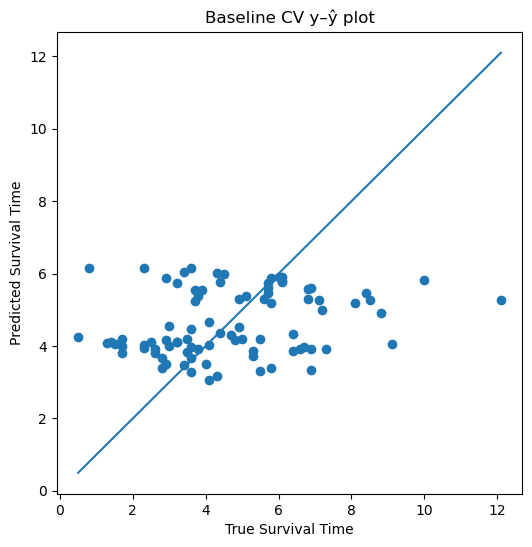

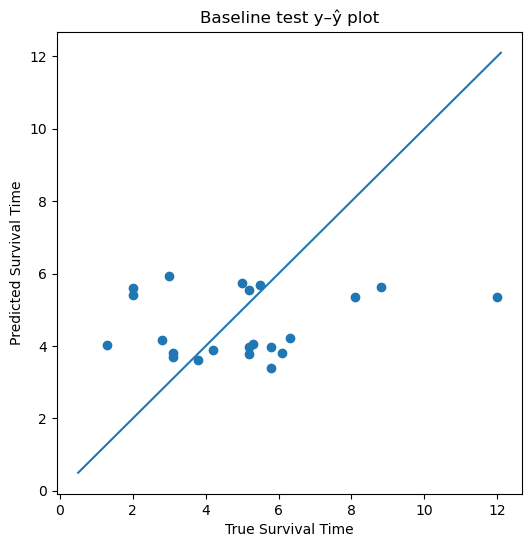

In [8]:
#Splitting the dataset for Cross Validation
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    X,
    y,
    train_final["Censored"].values,  # inclui censura aqui
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

#Baseline model with Linear Regression and Standard Scaler
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())

#Cross-validation to evaluate the baseline model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_hat_cv = cross_val_predict(baseline, X_train, y_train, cv=cv)

mse_cv =mean_squared_error(y_train, y_hat_cv)
print("Cross-validated MSE:", mse_cv)

#Fitting the baseline model
baseline.fit(X_train, y_train)
y_test_hat = baseline.predict(X_test)

#Using MSE as error metric beacause for data with c=0 MSE=cMSE
mse_test = mean_squared_error(y_test, y_test_hat)
print("Final Test MSE:", mse_test)

#Y_y_hat plot
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_hat_cv)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Baseline CV y–ŷ plot")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_hat)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Baseline test y–ŷ plot")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()

In [9]:
# === Kaggle submission para o baseline ===

# (Re)treinar o baseline em TODO o train_final com as mesmas features dos modelos
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(train_final[model_features].values, train_final["SurvivalTime"].values)

# Verificar se o test não tem NaN nestas colunas
print(test[model_features].isnull().sum())

# Previsão no conjunto de teste
test_pred = baseline.predict(test[model_features])

# Criar submission no formato do sample_submission.csv (id, 0)
sub = pd.DataFrame({
    "id": test["id"],
    "0": test_pred
})

sub.to_csv("baseline-submission-01.csv", index=False)
print("Submission saved as baseline-submission-01.csv")


Age              0
Gender           0
Stage            0
TreatmentType    0
dtype: int64
Submission saved as baseline-submission-01.csv


c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<h1> Task 2 - Nonlinear models <h2>

<h2> Tssk 2.1 - Development <h2>

<h3> Polynomial Model <h3>

In [10]:
#Define the regressor by Ridge regularization to use in the pipeline
def pick_regressor(use_ridge=False, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)): #Defining the value of lambda for Ridge regularization(penalty term)
    if use_ridge:
        alphas_array = np.array(ridge_alphas)  # If ridge is used, convert the alphas to a numpy array
        regressor = RidgeCV(alphas=alphas_array)  # The model is a linear regression with Ridge
    else:
        regressor = LinearRegression()  # If ridge is not used, the model is a simple linear regression
    return regressor

#Creates a validation function for polynomial regression models to choose the best degree and model
def train_polynomial_cv(
    X_train, y_train,  #Split data from the make_train_val_test_split function
    degrees=range(1, 8),
    cv=5, 
    random_state=42,
    use_ridge=False,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)):
    
    #Cross-validation setup
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {
        'degrees': [],
        'n_features': [],
        'mse_train': [],
        'mse_cv': []}
    
    #Training for each degree
    for degree in degrees:
        #Create pipeline with StandardScaler, PolynomialFeatures, and chosen regressor
        regr = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
        model = make_pipeline(
            StandardScaler(with_mean=True),
            PolynomialFeatures(degree=degree, include_bias=False),
            regr)
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()

        #Train on full training set to get training error
        model.fit(X_train, y_train)
        n_features = model.named_steps['polynomialfeatures'].n_output_features_
        
        #Store results
        results['degrees'].append(degree)
        results['n_features'].append(n_features)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        print(f"Degree {degree}:"
              f"Number features = {n_features}, "
              f"Train MSE = {mse_train:.2f}, "
              f"CV MSE = {mse_cv:.2f}")
    
    #Select best degree (lowest CV MSE)
    best_idx = np.argmin(results['mse_cv'])
    best_degree = results['degrees'][best_idx]
    best_cv_mse = results['mse_cv'][best_idx]
    
    print(f"BEST POLYNOMIAL DEGREE: {best_degree} (CV MSE = {best_cv_mse:.2f})")

    # Train final model with best degree - FIXED
    regr_final = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        PolynomialFeatures(degree=best_degree, include_bias=False),
        regr_final)

    best_model.fit(X_train, y_train)
    
    return best_model, results

def plot_polynomial_results(results_linear, results_ridge, save_path=None):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. MSE vs Degree
    ax = axes[0, 0]
    ax.plot(results_linear['degrees'], results_linear['mse_train'], 
            'o-', label='Train (No Ridge)', color='blue', alpha=0.7)
    ax.plot(results_linear['degrees'], results_linear['mse_cv'], 
            's-', label='CV (No Ridge)', color='blue')
    ax.plot(results_ridge['degrees'], results_ridge['mse_train'], 
            'o-', label='Train (Ridge)', color='red', alpha=0.7)
    ax.plot(results_ridge['degrees'], results_ridge['mse_cv'], 
            's-', label='CV (Ridge)', color='red')
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('MSE')
    ax.set_title('MSE vs Polynomial Degree')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Feature Complexity
    ax = axes[0, 1]
    ax.plot(results_linear['degrees'], results_linear['n_features'], 
            'o-', label='Number of Features', color='green', linewidth=2)
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('Number of Features')
    ax.set_title('Model Complexity (Feature Count)')
    ax.legend()
    ax.grid(True, alpha=0.3)


Polynomial Regression Without Ridge Regularization
Degree 1:Number features = 4, Train MSE = 3.84, CV MSE = 4.49
Degree 2:Number features = 14, Train MSE = 3.36, CV MSE = 6.29
Degree 3:Number features = 34, Train MSE = 2.43, CV MSE = 26.71
Degree 4:Number features = 69, Train MSE = 1.43, CV MSE = 232.44
Degree 5:Number features = 125, Train MSE = 0.99, CV MSE = 107949.40
BEST POLYNOMIAL DEGREE: 1 (CV MSE = 4.49)
Polynomial Regression With Ridge Regularization
Degree 1:Number features = 4, Train MSE = 3.88, CV MSE = 4.57
Degree 2:Number features = 14, Train MSE = 3.92, CV MSE = 4.75
Degree 3:Number features = 34, Train MSE = 4.00, CV MSE = 5.11
Degree 4:Number features = 69, Train MSE = 3.93, CV MSE = 5.14
Degree 5:Number features = 125, Train MSE = 3.52, CV MSE = 6.63
BEST POLYNOMIAL DEGREE: 1 (CV MSE = 4.57)


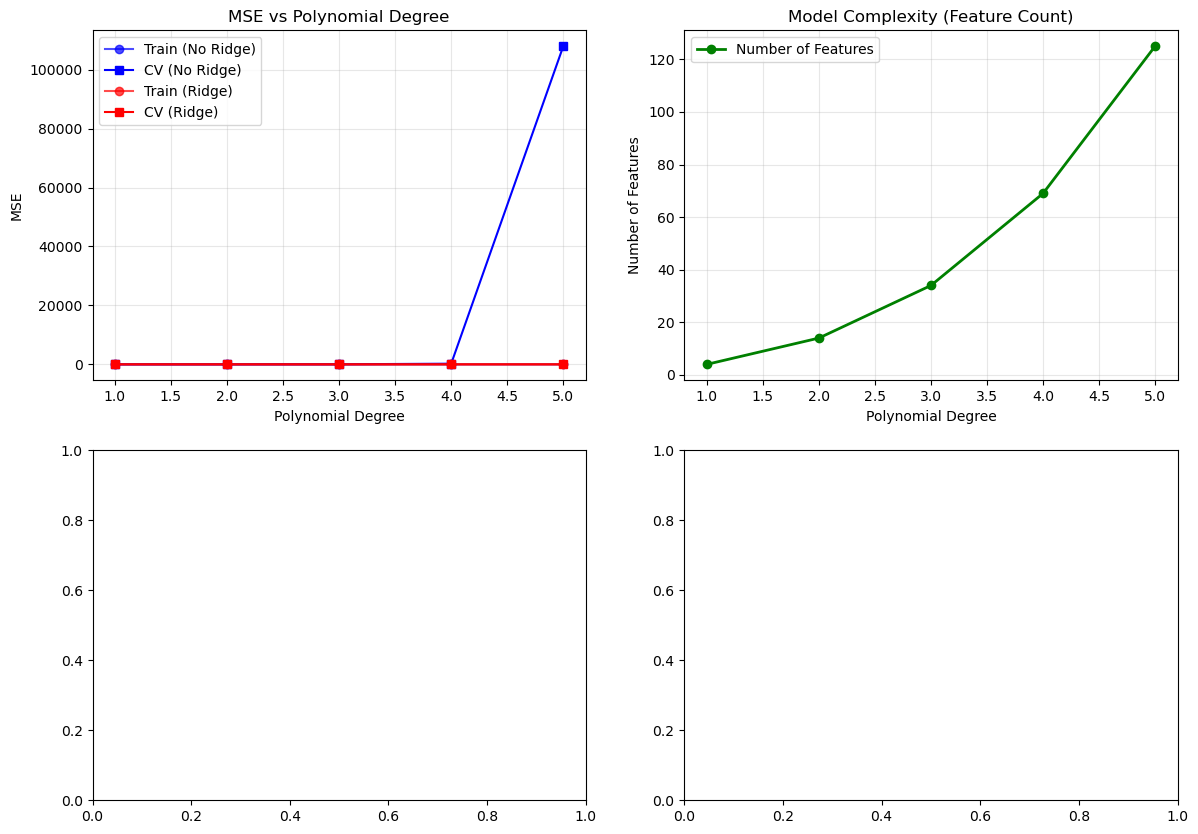

In [11]:
#Polynomial Regression without Ridge regularization
print("Polynomial Regression Without Ridge Regularization")

poly_model_linear, poly_results_linear = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=False, 
    random_state=42)

#Polynomial Regression without Ridge regularization
print("Polynomial Regression With Ridge Regularization")

poly_model_ridge, poly_results_ridge = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=True, 
    ridge_alphas=(0.1, 1.0, 10.0, 100.0, 1000.0),  
    random_state=42)

plot_polynomial_results(poly_results_linear, poly_results_ridge)


<h3> KNN Model <h3>

In [12]:
#k-Nearest Neighbors regression with Cross-Validation to choose the best k
def train_knn_cv(X_train, y_train, k_values=range(1, 30), cv=5, random_state=42):
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {'k_values': [], 'mse_train': [], 'mse_cv': [], 'std_cv': []}
    
    print("k-Nearest Neighbors:")
    
    #Training for each k
    for k in k_values:
        model = make_pipeline(
            StandardScaler(with_mean=True),
            KNeighborsRegressor(n_neighbors=k))
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()
        
        model.fit(X_train, y_train)
        
        results['k_values'].append(k)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        if k <= 10 or k % 5 == 0:
            print(f"k={k:2d}: Train MSE={mse_train:.2f}, CV MSE={mse_cv:.2f}")
    
    best_idx = np.argmin(results['mse_cv'])
    best_k = results['k_values'][best_idx]
    print(f"\nBEST k: {best_k} (CV MSE = {results['mse_cv'][best_idx]:.2f})")
    
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        KNeighborsRegressor(n_neighbors=best_k)
    )
    best_model.fit(X_train, y_train)
    
    return best_model, results

In [13]:
knn_model, knn_results = train_knn_cv(
        X_train, y_train,
        k_values=range(1, 30), 
        cv=5,
        random_state=42)

k-Nearest Neighbors:
k= 1: Train MSE=0.33, CV MSE=8.70
k= 2: Train MSE=2.06, CV MSE=6.83
k= 3: Train MSE=2.58, CV MSE=5.58
k= 4: Train MSE=2.91, CV MSE=5.05
k= 5: Train MSE=3.11, CV MSE=4.76
k= 6: Train MSE=3.18, CV MSE=4.84
k= 7: Train MSE=3.27, CV MSE=4.56
k= 8: Train MSE=3.35, CV MSE=4.49
k= 9: Train MSE=3.51, CV MSE=4.31
k=10: Train MSE=3.58, CV MSE=4.39
k=15: Train MSE=3.75, CV MSE=4.31
k=20: Train MSE=3.88, CV MSE=4.31
k=25: Train MSE=3.97, CV MSE=4.37

BEST k: 18 (CV MSE = 4.24)


<h2> Task 2.2 - Evaluation <h2>

In [14]:
#Comprehensive evaluation function
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, 
                                 model_name, cv=5, random_state=42):

    #Cross-validation predictions on training set
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
    
    #Train set predictions (refit on full training set)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    
    #Test set predictions
    y_test_pred = model.predict(X_test)
    
    #Calculate errors
    train_errors = y_train - y_train_pred
    cv_errors = y_train - y_train_pred_cv
    test_errors = y_test - y_test_pred
    
    #Compile results
    results = {
        'Model': model_name,
        
        # Training and Cross-Validation Metrics
        'Train_MSE': mean_squared_error(y_train, y_train_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'CV_MSE': mean_squared_error(y_train, y_train_pred_cv),
        'CV_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_cv)),
        
        # Test Set Metrics
        'Test_MSE': mean_squared_error(y_test, y_test_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))}
        
    return results

#Function to compare multiple models
def compare_models(models_dict, X_train, y_train, X_test, y_test, cv=5, random_state=42):
    
    all_results = []

    for model_name, model in models_dict.items():
        results = evaluate_model_comprehensive(
            model, X_train, y_train, X_test, y_test, 
            model_name, cv, random_state)
        all_results.append(results)
    
    #Create comprehensive DataFrame
    results_df = pd.DataFrame([{k: v for k, v in r.items() 
                                if k not in ['y_test_pred', 'test_errors']} 
                               for r in all_results])
    
    return results_df, all_results

def print_comparison_tables(results_df):

    #Main metrics table
    main_metrics = results_df[['Model', 'Train_MSE', 'CV_MSE', 'Test_MSE', 
                                'Train_RMSE', 'CV_RMSE', 'Test_RMSE']].copy()
    print(main_metrics.to_string(index=False))
    
    print("Ranking of Models Based on Test MSE:")
    #Ranking
    ranking = results_df[['Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']].copy()
    ranking = ranking.sort_values('Test_MSE')
    ranking['Rank'] = range(1, len(ranking) + 1)
    ranking = ranking[['Rank', 'Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']]
    print(ranking.to_string(index=False))
    
    #Print best model
    best_model = ranking.iloc[0]
    print(f"Best Model: {best_model['Model']}")
    print(f"Test MSE: {best_model['Test_MSE']:.4f}")
    print(f"Test RMSE: {best_model['Test_RMSE']:.4f}")    
    return ranking

#Function to plot model comparison with MSE values
def plot_model_comparison(results_df, all_results, y_test):
    
    n_models = len(results_df)
    x_pos = np.arange(n_models)
    width = 0.25
    plt.figure(figsize=(12, 6))
    plt.bar(x_pos - width, results_df['Train_MSE'], width, label='Train MSE', alpha=0.8)
    plt.bar(x_pos, results_df['CV_MSE'], width, label='CV MSE', alpha=0.8)
    plt.bar(x_pos + width, results_df['Test_MSE'], width, label='Test MSE', alpha=0.8)
    plt.xlabel('Model')
    plt.ylabel('MSE')
    plt.title('MSE Comparison Across Models')
    plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

                       Model  Train_MSE   CV_MSE  Test_MSE  Train_RMSE  CV_RMSE  Test_RMSE
Baseline (Linear Regression)   3.898565 4.481478  5.893445    1.974478 2.116950   2.427642
 Polynomial Ridge (Degree 1)   3.907282 4.545916  5.783719    1.976685 2.132115   2.404936
                 k-NN (k=18)   3.869564 4.227796  5.814891    1.967121 2.056160   2.411408
Ranking of Models Based on Test MSE:
 Rank                        Model  Test_MSE  Test_RMSE   CV_MSE
    1  Polynomial Ridge (Degree 1)  5.783719   2.404936 4.545916
    2                  k-NN (k=18)  5.814891   2.411408 4.227796
    3 Baseline (Linear Regression)  5.893445   2.427642 4.481478
Best Model: Polynomial Ridge (Degree 1)
Test MSE: 5.7837
Test RMSE: 2.4049


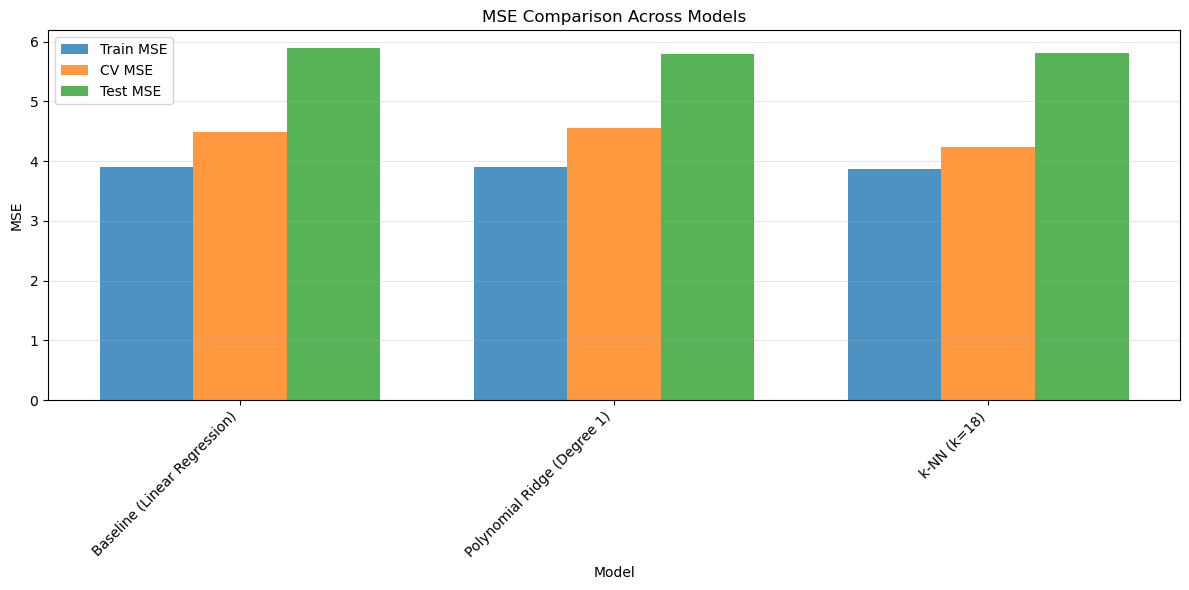

In [15]:
best_degree_ridge = poly_results_ridge['degrees'][np.argmin(poly_results_ridge['mse_cv'])]
best_k = knn_results['k_values'][np.argmin(knn_results['mse_cv'])]

models_dict = {
    "Baseline (Linear Regression)": baseline,
    f"Polynomial Ridge (Degree {best_degree_ridge})": poly_model_ridge,
    f"k-NN (k={best_k})": knn_model,
}

#Comprehensive comparison
results_df, all_results = compare_models(
    models_dict, X_train, y_train, X_test, y_test, 
    cv=5, random_state=42)
    
#rint comparison tables
ranking = print_comparison_tables(results_df)
    
#Create plot
plot_model_comparison (results_df, all_results, y_test)

In [17]:
import os


# 1) Select the best model according to Test_MSE from the comparison table
#    (lower Test_MSE is better)
best_row = results_df.sort_values("Test_MSE").iloc[0]
best_model_name = best_row["Model"]
print(f"\nBest model for Task 2: {best_model_name}")

# 2) Retrieve the corresponding model object from models_dict
best_model = models_dict[best_model_name]

# 3) Train the best model on the full training data using the same model_features
X_full = train_final[model_features].values
y_full = train_final["SurvivalTime"].values

best_model.fit(X_full, y_full)

# 4) Prepare the test features (must use the same model_features)
X_test_full = test[model_features].values

# 5) Predict survival time for the test set
test_pred_nonlinear = best_model.predict(X_test_full)

# 6) Ensure the output directory exists (relative to the notebook path)
os.makedirs("../outputs/csv", exist_ok=True)

# 7) Build the submission DataFrame in Kaggle format (columns: id, 0)
sub_nonlinear = pd.DataFrame({
    "id": test["id"],   # id column from test_data.csv
    "0": test_pred_nonlinear  # predicted SurvivalTime
})

# 8) Save the submission file for Task 2
output_path = "../outputs/csv/Nonlinear-submission-01.csv"
sub_nonlinear.to_csv(output_path, index=False)

print(f"Nonlinear submission saved to {output_path}")



Best model for Task 2: Polynomial Ridge (Degree 1)
Nonlinear submission saved to ../outputs/csv/Nonlinear-submission-01.csv


<h1> Task 3 - Handling missing data </h1>
<h2> Task 3.1 - Missing data imputation </h2>

Train size used in Task 3.1 (with missing features allowed): 161
Missing values per feature (Task 3.1 dataset):
Age                   0
Gender                0
Stage                 0
GeneticRisk          27
TreatmentType         0
ComorbidityIndex     18
TreatmentResponse    11
dtype: int64
Task 3.1 - Train size: 128
Task 3.1 - Test size: 33

=== Evaluating imputation strategy: mean ===

=== Evaluating imputation strategy: median ===

=== Evaluating imputation strategy: most_frequent ===

=== Evaluating imputation strategy: constant_zero ===

=== Evaluating imputation strategy: knn_5 ===

=== Task 3.1 - Baseline with different imputation strategies ===
     Strategy   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE  Test_Error_Mean  Test_Error_Std  Test_Error_Min  Test_Error_Max
         mean 3.724064 1.929783  3.385637   1.840010        -0.378024        1.800759       -3.330081        4.089464
        knn_5 3.687735 1.920348  3.403570   1.844877        -0.381239        1.805056       -3.305248 

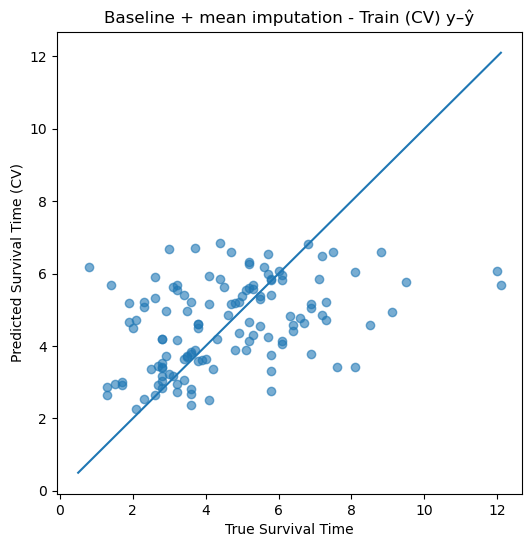

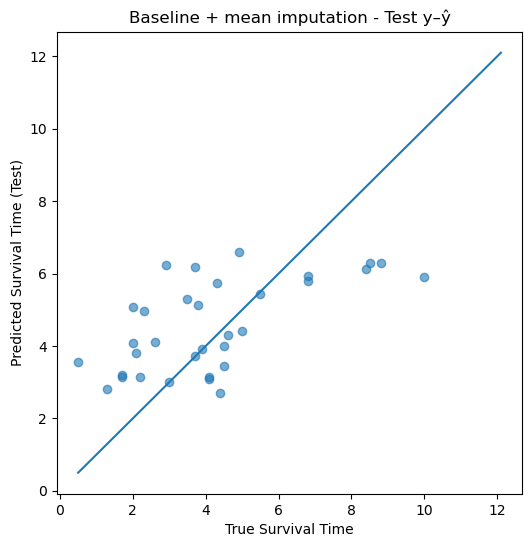

In [18]:
from sklearn.impute import SimpleImputer, KNNImputer

# ============================================================
# 1. Build supervised dataset including rows with missing features
# ============================================================

# We now include rows that may have missing feature values.
# We still restrict to uncensored patients (Censored == 0) and
# require SurvivalTime to be observed (no missing target).

full_feature_cols = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex",
    "TreatmentResponse",
]

supervised_mask = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_imp = train.loc[supervised_mask].copy()

print("Train size used in Task 3.1 (with missing features allowed):", len(train_imp))
print("Missing values per feature (Task 3.1 dataset):")
print(train_imp[full_feature_cols].isnull().sum())

X_imp = train_imp[full_feature_cols].values
y_imp = train_imp["SurvivalTime"].values

# Train/test split for evaluation (similar to Task 1.2 but now with missing features)
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp,
    y_imp,
    test_size=0.2,
    random_state=42
)

print("Task 3.1 - Train size:", len(X_train_imp))
print("Task 3.1 - Test size:", len(X_test_imp))

# ============================================================
# 2. Imputation strategies + baseline model (Linear Regression)
# ============================================================

# Define different imputation strategies to try with the baseline model
imputation_strategies = {
    "mean": SimpleImputer(strategy="mean"),
    "median": SimpleImputer(strategy="median"),
    "most_frequent": SimpleImputer(strategy="most_frequent"),
    "constant_zero": SimpleImputer(strategy="constant", fill_value=0.0),
    "knn_5": KNNImputer(n_neighbors=5, weights="uniform"),
}

def evaluate_baseline_with_imputer(imputer_name, imputer, 
                                   X_train, y_train, X_test, y_test,
                                   cv_splits=5, random_state=42):
    """
    Build a pipeline: Imputer -> StandardScaler -> LinearRegression,
    evaluate it with cross-validation on the training data and 
    compute test performance.
    Returns a dictionary with metrics and the fitted model.
    """
    # Build pipeline
    model = make_pipeline(
        imputer,
        StandardScaler(with_mean=True),
        LinearRegression()
    )
    
    # Cross-validation on training data
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    cv_mse = mean_squared_error(y_train, y_train_pred_cv)
    cv_rmse = np.sqrt(cv_mse)
    
    # Fit on training set and evaluate on test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    
    # Error statistics (for slides)
    test_errors = y_test - y_test_pred
    stats = {
        "Strategy": imputer_name,
        "CV_MSE": cv_mse,
        "CV_RMSE": cv_rmse,
        "Test_MSE": test_mse,
        "Test_RMSE": test_rmse,
        "Test_Error_Mean": np.mean(test_errors),
        "Test_Error_Std": np.std(test_errors),
        "Test_Error_Min": np.min(test_errors),
        "Test_Error_Max": np.max(test_errors),
        "model": model,  # keep fitted model in case this is the best
        "y_test_pred": y_test_pred,
        "y_train_pred_cv": y_train_pred_cv,
    }
    return stats

# Run all strategies and collect results
imputation_results = []
for name, imp in imputation_strategies.items():
    print(f"\n=== Evaluating imputation strategy: {name} ===")
    stats = evaluate_baseline_with_imputer(
        name, imp,
        X_train_imp, y_train_imp,
        X_test_imp, y_test_imp,
        cv_splits=5,
        random_state=42
    )
    imputation_results.append(stats)

# Build a DataFrame with the results (for tables in slides)
imp_results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k not in ["model", "y_test_pred", "y_train_pred_cv"]}
    for d in imputation_results
])

print("\n=== Task 3.1 - Baseline with different imputation strategies ===")
print(imp_results_df.sort_values("Test_MSE").to_string(index=False))

# ============================================================
# 3. Pick the best imputation strategy (based on CV or Test MSE)
# ============================================================

# Here we choose based on Test_MSE (you can justify in slides)
best_row_imp = imp_results_df.sort_values("Test_MSE").iloc[0]
best_strategy_name = best_row_imp["Strategy"]
print(f"\nBest imputation strategy for baseline: {best_strategy_name}")

# Retrieve the corresponding full stats (including model and predictions)
best_stats_full = next(d for d in imputation_results if d["Strategy"] == best_strategy_name)
baseline_imputed_best = best_stats_full["model"]
y_train_cv_best = best_stats_full["y_train_pred_cv"]
y_test_pred_best = best_stats_full["y_test_pred"]

# ============================================================
# 4. y–ŷ plots for the best imputation strategy (baseline)
# ============================================================

plt.figure(figsize=(6, 6))
plt.scatter(y_train_imp, y_train_cv_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (CV)")
plt.title(f"Baseline + {best_strategy_name} imputation - Train (CV) y–ŷ")
min_y, max_y = y_imp.min(), y_imp.max()
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test_imp, y_test_pred_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Test)")
plt.title(f"Baseline + {best_strategy_name} imputation - Test y–ŷ")
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

# These plots + imp_results_df table are what you need to compare Task 3.1
# with the original baseline from Task 1.2 in your slides.


# ============================================================
# 5. Apply best imputation strategy to best models from Task 2
# ============================================================

<h3> Task 3.1 - Applying best imputation to nonlinear models </h3>


=== Task 3.1 - Models with best imputation strategy ===
                    Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
          Baseline + mean   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
Poly Ridge (deg=1) + mean   3.043543    1.744575 3.646274 1.909522  3.420821   1.849546
       k-NN (k=18) + mean   3.206947    1.790795 3.596984 1.896572  3.699446   1.923394


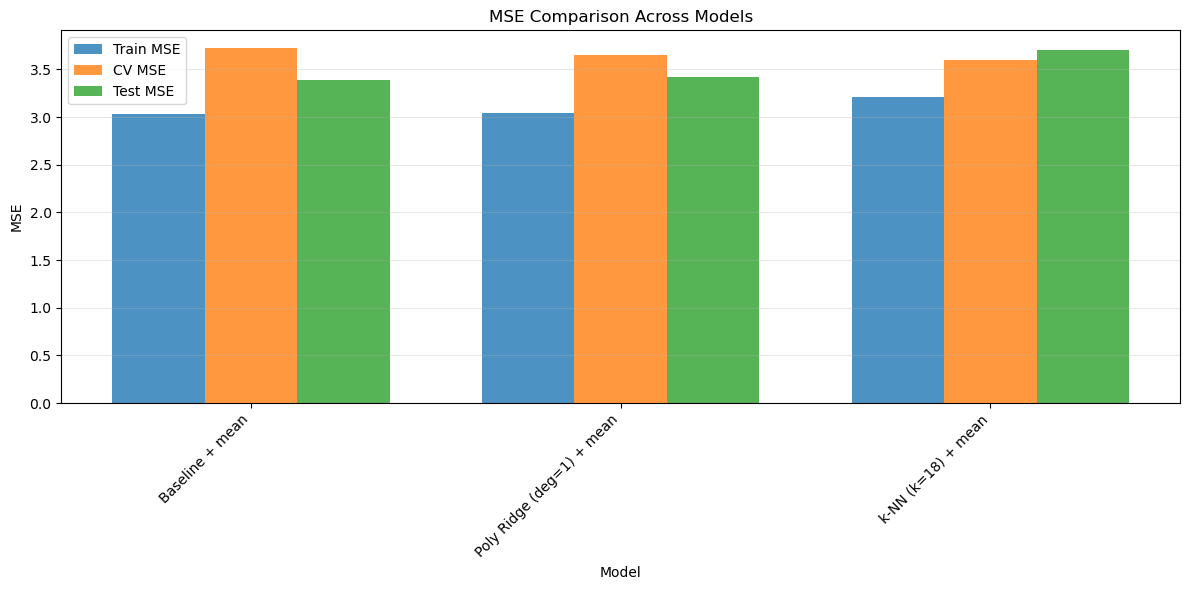

In [19]:
from sklearn.impute import SimpleImputer, KNNImputer

# Rebuild an unfitted imputer corresponding to best_strategy_name
# (so we do not reuse the already-fitted one from before)
if best_strategy_name == "mean":
    best_imputer = SimpleImputer(strategy="mean")
elif best_strategy_name == "median":
    best_imputer = SimpleImputer(strategy="median")
elif best_strategy_name == "most_frequent":
    best_imputer = SimpleImputer(strategy="most_frequent")
elif best_strategy_name == "constant_zero":
    best_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
elif best_strategy_name == "knn_5":
    best_imputer = KNNImputer(n_neighbors=5, weights="uniform")
else:
    raise ValueError(f"Unknown best strategy: {best_strategy_name}")

# We reuse the best hyperparameters found in Task 2:
#   - best_degree_ridge (for Polynomial Ridge)
#   - best_k (for k-NN)
# They should already be defined from Task 2.

# Polynomial Ridge with imputation
poly_ridge_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    PolynomialFeatures(degree=best_degree_ridge, include_bias=False),
    RidgeCV(alphas=np.array([0.1, 1.0, 10.0, 100.0, 1000.0]))
)

# k-NN with imputation
knn_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    KNeighborsRegressor(n_neighbors=best_k)
)

# Baseline with the best imputer (for comparison in this task)
baseline_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    LinearRegression()
)

# Compare the three models on the Task 3.1 dataset (with missing features)
models_task3 = {
    f"Baseline + {best_strategy_name}": baseline_imputed,
    f"Poly Ridge (deg={best_degree_ridge}) + {best_strategy_name}": poly_ridge_imputed,
    f"k-NN (k={best_k}) + {best_strategy_name}": knn_imputed,
}

results_task3_df, _ = compare_models(
    models_task3,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)

print("\n=== Task 3.1 - Models with best imputation strategy ===")
print(results_task3_df.to_string(index=False))

# Optional: plot comparison of MSE across models in Task 3.1
plot_model_comparison(results_task3_df, _, y_test_imp)

<h2> Task 3.2 - Models that do not require imputation </h2>

In [20]:
import sys
print(sys.executable)

import sys
!{sys.executable} -m pip install catboost


from catboost import CatBoostRegressor, Pool
print("CatBoost import OK")

c:\Users\DESKTOP\anaconda3\python.exe
CatBoost import OK



=== Task 3.2 - Comparison: Baseline (with imputation) vs HistGradientBoosting ===
                                        Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
                      Baseline + mean imputer   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
HistGradientBoostingRegressor (no imputation)   1.599550    1.264733 4.582118 2.140588  4.045936   2.011451


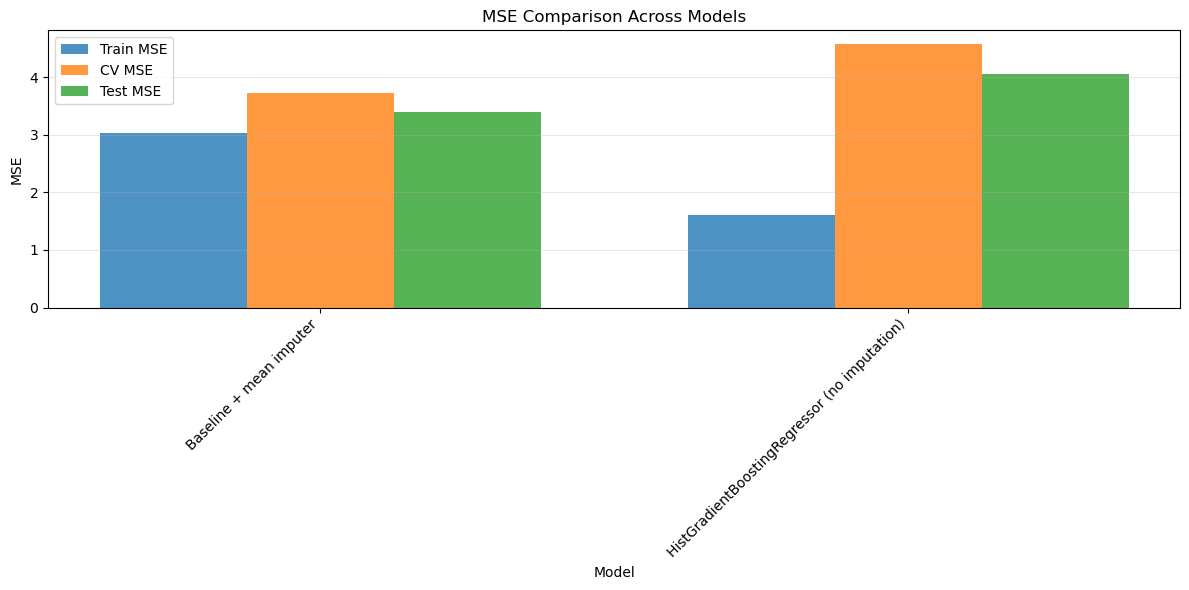

In [22]:

# -------------------------------------------------------------------
# 1. Baseline with best imputation strategy (for comparison)
#    We rebuild the baseline pipeline using the best_imputer found in Task 3.1.
# -------------------------------------------------------------------
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression 

baseline_imputed_t32 = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    LinearRegression()
)

# -------------------------------------------------------------------
# 2. HistGradientBoostingRegressor
#    This model natively supports missing values (NaN) in the features.
#    We do NOT impute anything here, we pass X with NaN directly.
# -------------------------------------------------------------------

hgb_model = HistGradientBoostingRegressor(
    max_iter=400,
    learning_rate=0.05,
    max_depth=None,
    l2_regularization=0.0,
    random_state=42
)

# We will compare:
#   - Baseline + best imputation (from Task 3.1)
#   - HistGradientBoostingRegressor (no imputation; uses raw X with NaN)
models_task32 = {
    f"Baseline + {best_strategy_name} imputer": baseline_imputed_t32,
    "HistGradientBoostingRegressor (no imputation)": hgb_model,
}

# Note: we evaluate on the Task 3.1 supervised dataset (train_imp),
# which includes missing feature values.
results_task32_df, _ = compare_models(
    models_task32,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)

print("\n=== Task 3.2 - Comparison: Baseline (with imputation) vs HistGradientBoosting ===")
print(results_task32_df.to_string(index=False))

# Optional: plot MSE comparison for slides
plot_model_comparison(results_task32_df, _, y_test_imp)

# -------------------------------------------------------------------


In [26]:

import catboost
print(catboost.__version__)


1.2.8


In [28]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# 1) Load data (ficheiros já carregados para /content)
train = pd.read_csv("../data/train_data.csv")

full_feature_cols = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
]

# 2) Usar todos os pacientes com SurvivalTime conhecido (inclui censurados)
aft_mask = train["SurvivalTime"].notna()
train_aft = train.loc[aft_mask].copy()

X_aft = train_aft[full_feature_cols].values
time_aft = train_aft["SurvivalTime"].values
cens_aft = train_aft["Censored"].values  # 0 = evento, 1 = censura

def make_aft_labels(time, censored):
    """
    Para CatBoost AFT:
      - não censurado (c=0): [T, T]
      - censurado à direita (c=1): [T, +inf]
    """
    lower = time
    upper = np.where(censored == 1, np.inf, time)
    return np.vstack([lower, upper]).T

y_aft = make_aft_labels(time_aft, cens_aft)

# 3) Train/validation split
X_train, X_val, y_train, y_val, cens_train, cens_val = train_test_split(
    X_aft, y_aft, cens_aft, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_val, y_val)

# 4) Modelo AFT: atenção ao nome da loss_function
aft_model = CatBoostRegressor(
    loss_function="SurvivalAft:dist=Normal",  # <--- aqui muda!
    eval_metric="SurvivalAft",
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=False
)

aft_model.fit(train_pool, eval_set=val_pool)

# 5) Predições em log-tempo -> exponentiamos
y_pred_log = aft_model.predict(val_pool)
y_pred = np.exp(y_pred_log)

# 6) cMSE
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

time_val = y_val[:, 0]   # limite inferior
cMSE_val = error_metric(time_val, y_pred, cens_val)

print("CatBoost AFT - validation cMSE:", cMSE_val)
print("Number of validation samples:", len(time_val))

Got unsafe target value = inf at object #6 of dataset learn
Got unsafe target value = inf at object #2 of dataset test #0


CatBoost AFT - validation cMSE: 3.0603373045665765
Number of validation samples: 48
